In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

MODEL_SAVE_PATH = '/content/gdrive/My Drive/Colab Notebooks/dacon_12/model_save/'

Mounted at /content/gdrive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Feb  9 08:11:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
!pip install timm

     |████████████████████████████████| 245kB 6.5MB/s 


In [5]:
pip install antialiased-cnns

In [6]:
from google.colab import output

DATA_ZIP_PATH = '/content/gdrive/My Drive/Colab Notebooks/data/data_2/'

# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/gdrive/My Drive/Colab Notebooks/data/data_2_2.zip" "data_2_2.zip"
# data_2.zip을 현재 디렉터리에 압축해제
!unzip "data_2_2.zip"

Archive:  data_2_2.zip
  inflating: dirty_mnist_2nd.zip     
  inflating: dirty_mnist_2nd_answer.csv  
  inflating: mnist_data.zip          
  inflating: sample_submission.csv   
  inflating: test_dirty_mnist_2nd.zip  


In [7]:
# 현재 디렉터리에 dirty_mnist라는 폴더 생성
!mkdir "./dirty_mnist_2nd"
#dirty_mnist.zip라는 zip파일을 dirty_mnist라는 폴더에 압축 풀기
!unzip "dirty_mnist_2nd.zip" -d "./dirty_mnist_2nd/"
# 현재 디렉터리에 test_dirty_mnist라는 폴더 생성
!mkdir "./test_dirty_mnist_2nd"
#test_dirty_mnist.zip라는 zip파일을 test_dirty_mnist라는 폴더에 압축 풀기
!unzip "test_dirty_mnist_2nd.zip" -d "./test_dirty_mnist_2nd/"
# 출력 결과 지우기
output.clear()

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import imutils
import zipfile
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from google.colab import output

from sklearn.model_selection import KFold

import timm
import antialiased_cnns
from antialiased_cnns import BlurPool
import re

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#dirty_mnist_answer = pd.read_csv(DIRTY_MNIST_ANSWER_PATH)

In [ ]:
dirty_mnist_answer = pd.read_csv('dirty_mnist_2nd_answer.csv')
# dirty_mnist라는 디렉터리 속에 들어있는 파일들의 이름을 
# namelist라는 변수에 저장
#namelist = os.listdir('./dirty_mnist/')

In [ ]:
dirty_mnist_answer

,index,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
0,0,1,1,0,1,0,1,0,0,0,0,1,1,0,0,1,1,0,1,1,0,1,0,0,1,1,1
1,1,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,1
2,2,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,0,1,1,1,0,1,1,1,0
3,3,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,1,0,1,1,0,1,1,0,1,0
4,4,0,1,0,1,0,1,0,1,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,0,1,1,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,0,0,1,1,0
49996,49996,0,1,0,1,0,1,1,1,0,1,0,0,0,0,1,0,0,1,1,1,0,1,0,0,0,1
49997,49997,0,1,0,0,1,1,1,1,0,0,1,1,0,0,0,0,1,0,0,0,0,1,1,1,0,0
49998,49998,0,1,1,1,0,0,1,1,0,1,1,1,1,1,0,0,0,1,1,1,0,0,0,1,0,0


In [ ]:
#namelist = os.listdir(DIRTY_MNIST_PATH)

In [ ]:
# check on the images

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [ ]:
train_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])
eval_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])


class DatasetMNIST_check(torch.utils.data.Dataset):
    def __init__(self,
                 dir_path,
                 meta_df,
                 transforms,
                 augmentations=None):
        self.dir_path = dir_path
        self.meta_df = meta_df

        self.transforms = transforms
        self.augmentations = augmentations

    def __len__(self):
        return len(self.meta_df)

    def __getitem__(self,index):

        image = cv2.imread(self.dir_path +\
                           str(self.meta_df.iloc[index,0]).zfill(5) + '.png',
                           cv2.IMREAD_COLOR)

        image = self.transforms(image)

        
        
        # image = (image/255).astype('float')[..., np.newaxis]
        # might need to check on why this is necessary


        label = self.meta_df.iloc[index, 1:].values.astype('float')

        return image, torch.FloatTensor(label)

In [ ]:
class DatasetMNIST(torch.utils.data.Dataset):
    def __init__(self,
                 dir_path,
                 meta_df,
                 transforms,
                 augmentations=None):
        self.dir_path = dir_path
        self.meta_df = meta_df

        self.transforms = transforms
        self.augmentations = augmentations

    def __len__(self):
        return len(self.meta_df)

    def __getitem__(self,index):

        #image = cv2.imread(self.dir_path +\
        #                   str(self.meta_df.iloc[index,0]).zfill(5) + '.png',
        #                   cv2.IMREAD_COLOR)
        
        image = Image.open(
            self.dir_path+str(self.meta_df.iloc[index,0]).zfill(5) + '.png',
        ).convert('RGB')

        image = self.transforms(image)

        # image = (image/255).astype('float')[..., np.newaxis]
        # might need to check on why this is necessary

        label = self.meta_df.iloc[index, 1:].values.astype('float')

        return image, torch.FloatTensor(label)

In [ ]:
"""def applyBlurPool(Cin, Cout, kernel_size=3, stride=2, padding=1):
    
    antialiased = nn.Sequential(
        nn.Conv2d(Cin, Cout, kernel_size=kernel_size, stride=1, padding=padding),
        nn.SiLU(inplace=True),
        antialiased_cnns.BlurPool(Cout, stride=stride)
    )

    return antialiased"""

In [ ]:
"""def recursive_search(model,depth):
    # only for Conv2d --> antialiased Conv2d
    #go_deeper = False
    # if no ":" then stop recursive
    deeper=[]
    for i, child in enumerate(model.children()):
        str_child = str(child)

        # check if need to keep going 
        if re.search(':' ,str_child)!=None:
            deeper = depth
            print(depth)
            print(type(depth))
            deeper[-1] += 1
            deeper = deeper.append(i)
            recursive_search(child, deeper)
        else:
            if re.search('Conv2d', str_child)!=None:
                if re.search('stride=\(2, 2\)', str_child)!=None:
                    print(depth, i, str_child)"""

In [ ]:
def search(child,depth):

    str_child = str(child)

    if re.search(':' ,str_child)!=None:
        return None
    else:
        if re.search('Conv2d', str_child)!=None:
            if re.search('stride=\(2, 2\)', str_child)!=None:
                print(depth, str_child)

In [ ]:
def search_all_layers(child,depth):

    str_child = str(child)

    if re.search(':' ,str_child)!=None:
        return None
    else:
        print(depth, str_child)

In [ ]:
def search_all_layers_return_true(child,depth):

    str_child = str(child)

    if re.search(':' ,str_child)!=None:
        return False
    else:
        print(depth)
        return True

torch.Size([3, 256, 256])


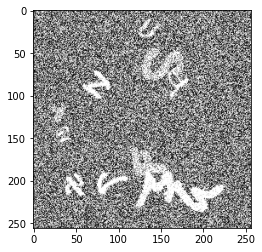

In [ ]:
train_dataset = DatasetMNIST_check('dirty_mnist_2nd/', dirty_mnist_answer, T.ToTensor())

train_data_loader = DataLoader(
        train_dataset,
        batch_size = 1,
        shuffle = True,
        num_workers=3
    )

image, label=next(iter(train_data_loader))
print(np.squeeze(image, axis=0).shape)
imshow(np.squeeze(image))

In [ ]:
"""train_dataset = DatasetMNIST_check('dirty_mnist_2nd/', dirty_mnist_answer, T.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4)

mean = 0.
std = 0.
nb_samples = 0.

for data, _ in train_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f'mean = {mean}')
print(f'std = {std}')"""

"train_dataset = DatasetMNIST_check('dirty_mnist_2nd/', dirty_mnist_answer, T.ToTensor())\ntrain_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4)\n\nmean = 0.\nstd = 0.\nnb_samples = 0.\n\nfor data, _ in train_loader:\n    batch_samples = data.size(0)\n    data = data.view(batch_samples, data.size(1), -1)\n    mean += data.mean(2).sum(0)\n    std += data.std(2).sum(0)\n    nb_samples += batch_samples\n\nmean /= nb_samples\nstd /= nb_samples\n\nprint(f'mean = {mean}')\nprint(f'std = {std}')"

In [ ]:
"""mean = [0.5350]
std = [0.3007]"""

'mean = [0.5350]\nstd = [0.3007]'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])


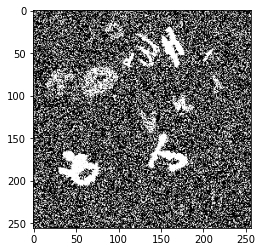

In [ ]:
train_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])

train_dataset = DatasetMNIST_check('dirty_mnist_2nd/', dirty_mnist_answer, train_transform)

train_data_loader = DataLoader(
        train_dataset,
        batch_size = 1,
        shuffle = True,
        num_workers=3
    )

image, label=next(iter(train_data_loader))
print(np.squeeze(image, axis=0).shape)
imshow(np.squeeze(image))

In [ ]:
# nn.Module을 상속 받아 MultiLabelResnet를 정의
class MultiLabelEfficientNet(nn.Module):
    def __init__(self):
        super(MultiLabelEfficientNet, self).__init__()
        #self.conv2d = nn.Conv2d(1, 3, 3, stride=1)
        self.model = timm.create_model('efficientnet_b0', pretrained=True)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 26)

    def forward(self, x):
        # resnet의 입력은 [3, N, N]으로
        # 3개의 채널을 갖기 때문에
        # resnet 입력 전에 conv2d를 한 층 추가
        #x = F.relu(self.conv2d(x))

        # resnet18을 추가
        # = F.relu(self.model(x))

        # 마지막 출력에 nn.Linear를 추가
        # multilabel을 예측해야 하기 때문에
        # softmax가 아닌 sigmoid를 적용
        x = torch.sigmoid(self.model(x))
        return x
# 모델 선언
efficientnet = MultiLabelEfficientNet()

In [ ]:
efficientnet

MultiLabelEfficientNet(
  (model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [ ]:
for i, child in enumerate(efficientnet.model.children()):
    just_search(child, i)
    for j, grandchild in enumerate(child.children()):
        search(grandchild, [i,j])
        for k, grandgrandchild in enumerate(grandchild.children()):
            search(grandgrandchild, [i,j,k])
            for l, grandgrandgrandchild in enumerate(grandgrandchild.children()):
                search(grandgrandgrandchild, [i,j,k,l])
                for m, ggrandgrandgrandchild in enumerate(grandgrandgrandchild.children()):
                    search(ggrandgrandgrandchild, [i,j,k,l,m])
                    for n, gggrandgrandgrandchild in enumerate(ggrandgrandgrandchild.children()):
                        search(gggrandgrandgrandchild, [i,j,k,l,m, n])

In [ ]:
for i, child in enumerate(efficientnet.model.children()):
    if i == 0:
        print(child)
    for j, grandchild in enumerate(child.children()):
        search(grandchild, [i,j])
        for k, grandgrandchild in enumerate(grandchild.children()):
            search(grandgrandchild, [i,j,k])
            for l, grandgrandgrandchild in enumerate(grandgrandchild.children()):
                if [i,j,k,l] == [3, 1, 0, 3]:
                    print(grandgrandgrandchild)
                if [i,j,k,l] == [3, 2, 0, 3]:
                    print(grandgrandgrandchild)
                if [i,j,k,l] == [3, 3, 0, 3]:
                    print(grandgrandgrandchild)
                if [i,j,k,l] == [3, 5, 0, 3]:
                    print(grandgrandgrandchild)
                for m, ggrandgrandgrandchild in enumerate(grandgrandgrandchild.children()):
                    search(ggrandgrandgrandchild, [i,j,k,l,m])
                    for n, gggrandgrandgrandchild in enumerate(ggrandgrandgrandchild.children()):
                        search(gggrandgrandgrandchild, [i,j,k,l,m, n])

Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False)
Conv2d(144, 144, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), groups=144, bias=False)
Conv2d(240, 240, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=240, bias=False)
Conv2d(672, 672, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), groups=672, bias=False)


In [ ]:
for i, child in enumerate(efficientnet.model.children()):
    if i == 0:
        child = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=(1,1), bias=False),
            nn.SiLU(inplace=True),
            BlurPool(32, stride=2)
        )
    for j, grandchild in enumerate(child.children()):
        for k, grandgrandchild in enumerate(grandchild.children()):
            for l, grandgrandgrandchild in enumerate(grandgrandchild.children()):
                if [i,j,k,l] == [3, 1, 0, 3]:
                    grandgrandchild = nn.Sequential(
                            nn.Conv2d(96, 96, kernel_size=(3,3), stride=1, padding=(1,1), groups=96, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(96, stride=2)
                        )
                    
                if [i,j,k,l] == [3, 2, 0, 3]:
                    grandgrandchild = nn.Sequential(
                            nn.Conv2d(144, 144, kernel_size=(5,5), stride=1, padding=(2,2), groups=144, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(144, stride=2)
                        )
                if [i,j,k,l] == [3, 3, 0, 3]:
                    grandgrandchild = nn.Sequential(
                            nn.Conv2d(240, 240, kernel_size=(3,3), stride=1, padding=(1,1), groups=240, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(240, stride=2)
                        )
                if [i,j,k,l] == [3, 5, 0, 3]:
                    grandgrandchild = nn.Sequential(
                            nn.Conv2d(672,672, kernel_size=(5,5), stride=1, padding=(2,2), groups=672, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(672, stride=2)
                        )
                for m, ggrandgrandgrandchild in enumerate(grandgrandgrandchild.children()):
                    search(ggrandgrandgrandchild, [i,j,k,l,m])
                    for n, gggrandgrandgrandchild in enumerate(ggrandgrandgrandchild.children()):
                        search(gggrandgrandgrandchild, [i,j,k,l,m, n])

In [ ]:
layers = []

for i, child in enumerate(efficientnet.model.children()):
    if i == 0:
        layers += [nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=(1,1), bias=False),
            nn.SiLU(inplace=True),
            BlurPool(32, stride=2)
        ]
    else:
        if search_all_layers_return_true(child, i): 
            print(child)
            print(child.modules())
            layers += child.modules()
    for j, grandchild in enumerate(child.children()):
        if search_all_layers_return_true(grandchild, [i,j]):
            print(grandchild)
            print(grandchild.modules())
            layers += grandchild.modules()
        for k, grandgrandchild in enumerate(grandchild.children()):
            if search_all_layers_return_true(grandgrandchild, [i,j,k]):
                layers += grandgrandchild.modules()
            for l, grandgrandgrandchild in enumerate(grandgrandchild.children()):
                if [i,j,k,l] == [3, 1, 0, 3]:
                    layers += [nn.Conv2d(96, 96, kernel_size=(3,3), stride=1, padding=(1,1), groups=96, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(96, stride=2)
                    ]
                    
                if [i,j,k,l] == [3, 2, 0, 3]:
                    layers += [nn.Conv2d(144, 144, kernel_size=(5,5), stride=1, padding=(2,2), groups=144, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(144, stride=2)
                    ]
                if [i,j,k,l] == [3, 3, 0, 3]:
                    layers += [nn.Conv2d(240, 240, kernel_size=(3,3), stride=1, padding=(1,1), groups=240, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(240, stride=2)
                    ]
                if [i,j,k,l] == [3, 5, 0, 3]:
                    layers += [nn.Conv2d(672,672, kernel_size=(5,5), stride=1, padding=(2,2), groups=672, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(672, stride=2)
                    ]
                if [i,j,k,l] is not [3, 1, 0, 3] or [3, 2, 0, 3] or [3, 3, 0, 3] or [3, 5, 0, 3]:
                    if search_all_layers_return_true(grandgrandgrandchild, [i,j,k,l]):
                        layers += grandgrandgrandchild.modules()
                for m, ggrandgrandgrandchild in enumerate(grandgrandgrandchild.children()):
                    if search_all_layers_return_true(ggrandgrandgrandchild, [i,j,k,l,m]):
                        layers += ggrandgrandgrandchild.modules()
                    for n, gggrandgrandgrandchild in enumerate(ggrandgrandgrandchild.children()):
                        if search_all_layers_return_true(gggrandgrandgrandchild, [i,j,k,l,m, n]):
                            layers += gggrandgrandgrandchild.modules()

BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
<generator object Module.modules at 0x7ff910baa200>
SiLU(inplace=True)
<generator object Module.modules at 0x7ff910baa200>
Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)
<generator object Module.modules at 0x7ff910baa200>
BatchNorm2d(1280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
<generator object Module.modules at 0x7ff910baa200>
SiLU(inplace=True)
<generator object Module.modules at 0x7ff910baa200>
SelectAdaptivePool2d (pool_type=avg, flatten=True)
<generator object Module.modules at 0x7ff910baa200>
AdaptiveAvgPool2d(output_size=1)
<generator object Module.modules at 0x7ff910ba8678>
Linear(in_features=1280, out_features=26, bias=True)
<generator object Module.modules at 0x7ff910baa200>


In [ ]:
layers

[Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
 SiLU(inplace=True),
 BlurPool(
   (pad): ReflectionPad2d([1, 2, 1, 2])
 ),
 BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 SiLU(inplace=True),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False),
 BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 SiLU(inplace=True),
 Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1)),
 SiLU(inplace=True),
 Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1)),
 Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False),
 BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Identity(),
 Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False),
 BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 SiLU(inplace=True),
 Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96, bias=False),
 SiLU(in

In [ ]:
layers = []

for i, child in enumerate(efficientnet.model.children()):
    if i == 0:
        layers += [nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=(1,1), bias=False),
            nn.SiLU(inplace=True),
            BlurPool(32, stride=2)
        ]
    else:
        if i != 3:
            if search_all_layers_return_true(child, i): 
                layers += child.modules()
    for j, grandchild in enumerate(child.children()):
        for k, grandgrandchild in enumerate(grandchild.children()):
            for l, grandgrandgrandchild in enumerate(grandgrandchild.children()):
                if [i,j,k,l] == [3, 1, 0, 3]:
                    layers += [nn.Conv2d(96, 96, kernel_size=(3,3), stride=1, padding=(1,1), groups=96, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(96, stride=2)
                    ]
                    
                if [i,j,k,l] == [3, 2, 0, 3]:
                    layers += [nn.Conv2d(144, 144, kernel_size=(5,5), stride=1, padding=(2,2), groups=144, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(144, stride=2)
                    ]
                if [i,j,k,l] == [3, 3, 0, 3]:
                    layers += [nn.Conv2d(240, 240, kernel_size=(3,3), stride=1, padding=(1,1), groups=240, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(240, stride=2)
                    ]
                if [i,j,k,l] == [3, 5, 0, 3]:
                    layers += [nn.Conv2d(672,672, kernel_size=(5,5), stride=1, padding=(2,2), groups=672, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(672, stride=2)
                    ]
                if [i,j,k,l] is not [3, 1, 0, 3] or [3, 2, 0, 3] or [3, 3, 0, 3] or [3, 5, 0, 3]:
                    if search_all_layers_return_true(grandgrandgrandchild, [i,j,k,l]):
                        layers += grandgrandgrandchild.modules()
                for m, ggrandgrandgrandchild in enumerate(grandgrandgrandchild.children()):
                    if search_all_layers_return_true(ggrandgrandgrandchild, [i,j,k,l,m]):
                        layers += ggrandgrandgrandchild.modules()
                    for n, gggrandgrandgrandchild in enumerate(ggrandgrandgrandchild.children()):
                        if search_all_layers_return_true(gggrandgrandgrandchild, [i,j,k,l,m, n]):
                            layers += gggrandgrandgrandchild.modules()

In [ ]:
layers = []

for i, child in enumerate(efficientnet.model.children()):
    if i == 0:
        layers += [nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=(1,1), bias=False),
            nn.SiLU(inplace=True),
            BlurPool(32, stride=2)
        ]
    else:
        if i != 3:
            if search_all_layers_return_true(child, i): 
                layers += child.modules()
    for j, grandchild in enumerate(child.children()):
        for k, grandgrandchild in enumerate(grandchild.children()):
            for l, grandgrandgrandchild in enumerate(grandgrandchild.children()):
                if [i,j,k,l] == [3, 1, 0, 3]:
                    layers += [nn.Conv2d(96, 96, kernel_size=(3,3), stride=1, padding=(1,1), groups=96, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(96, stride=2)
                    ]
                    
                elif [i,j,k,l] == [3, 2, 0, 3]:
                    layers += [nn.Conv2d(144, 144, kernel_size=(5,5), stride=1, padding=(2,2), groups=144, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(144, stride=2)
                    ]
                elif [i,j,k,l] == [3, 3, 0, 3]:
                    layers += [nn.Conv2d(240, 240, kernel_size=(3,3), stride=1, padding=(1,1), groups=240, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(240, stride=2)
                    ]
                elif [i,j,k,l] == [3, 5, 0, 3]:
                    layers += [nn.Conv2d(672,672, kernel_size=(5,5), stride=1, padding=(2,2), groups=672, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(672, stride=2)
                    ]
                else:
                    if search_all_layers_return_true(grandgrandgrandchild, [i,j,k,l]):
                        layers += grandgrandgrandchild.modules()
                for m, ggrandgrandgrandchild in enumerate(grandgrandgrandchild.children()):
                    if search_all_layers_return_true(ggrandgrandgrandchild, [i,j,k,l,m]):
                        layers += ggrandgrandgrandchild.modules()
                

1
2
[3, 0, 0, 0]
[3, 0, 0, 1]
[3, 0, 0, 2]
[3, 0, 0, 3, 0]
[3, 0, 0, 3, 1]
[3, 0, 0, 3, 2]
[3, 0, 0, 4]
[3, 0, 0, 5]
[3, 0, 0, 6]
[3, 1, 0, 0]
[3, 1, 0, 1]
[3, 1, 0, 2]
[3, 1, 0, 4]
[3, 1, 0, 5]
[3, 1, 0, 6, 0]
[3, 1, 0, 6, 1]
[3, 1, 0, 6, 2]
[3, 1, 0, 7]
[3, 1, 0, 8]
[3, 1, 1, 0]
[3, 1, 1, 1]
[3, 1, 1, 2]
[3, 1, 1, 3]
[3, 1, 1, 4]
[3, 1, 1, 5]
[3, 1, 1, 6, 0]
[3, 1, 1, 6, 1]
[3, 1, 1, 6, 2]
[3, 1, 1, 7]
[3, 1, 1, 8]
[3, 2, 0, 0]
[3, 2, 0, 1]
[3, 2, 0, 2]
[3, 2, 0, 4]
[3, 2, 0, 5]
[3, 2, 0, 6, 0]
[3, 2, 0, 6, 1]
[3, 2, 0, 6, 2]
[3, 2, 0, 7]
[3, 2, 0, 8]
[3, 2, 1, 0]
[3, 2, 1, 1]
[3, 2, 1, 2]
[3, 2, 1, 3]
[3, 2, 1, 4]
[3, 2, 1, 5]
[3, 2, 1, 6, 0]
[3, 2, 1, 6, 1]
[3, 2, 1, 6, 2]
[3, 2, 1, 7]
[3, 2, 1, 8]
[3, 3, 0, 0]
[3, 3, 0, 1]
[3, 3, 0, 2]
[3, 3, 0, 4]
[3, 3, 0, 5]
[3, 3, 0, 6, 0]
[3, 3, 0, 6, 1]
[3, 3, 0, 6, 2]
[3, 3, 0, 7]
[3, 3, 0, 8]
[3, 3, 1, 0]
[3, 3, 1, 1]
[3, 3, 1, 2]
[3, 3, 1, 3]
[3, 3, 1, 4]
[3, 3, 1, 5]
[3, 3, 1, 6, 0]
[3, 3, 1, 6, 1]
[3, 3, 1, 6, 2]
[3, 3, 1, 7]
[3, 3, 1, 

In [ ]:
layers = []

for i, child in enumerate(efficientnet.model.children()):
    if i != 3:
        if search_all_layers_return_true(child, i): 
            layers += child.modules()
    for j, grandchild in enumerate(child.children()):
        for k, grandgrandchild in enumerate(grandchild.children()):
            for l, grandgrandgrandchild in enumerate(grandgrandchild.children()):
                if [i,j,k,l] == [3, 1, 0, 3]:
                    layers += [nn.Conv2d(96, 96, kernel_size=(3,3), stride=1, padding=(1,1), groups=96, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(96, stride=2)
                    ]
                    
                elif [i,j,k,l] == [3, 2, 0, 3]:
                    layers += [nn.Conv2d(144, 144, kernel_size=(5,5), stride=1, padding=(2,2), groups=144, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(144, stride=2)
                    ]
                elif [i,j,k,l] == [3, 3, 0, 3]:
                    layers += [nn.Conv2d(240, 240, kernel_size=(3,3), stride=1, padding=(1,1), groups=240, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(240, stride=2)
                    ]
                elif [i,j,k,l] == [3, 5, 0, 3]:
                    layers += [nn.Conv2d(672,672, kernel_size=(5,5), stride=1, padding=(2,2), groups=672, bias=False),
                            nn.SiLU(inplace=True),
                            antialiased_cnns.BlurPool(672, stride=2)
                    ]
                else:
                    if search_all_layers_return_true(grandgrandgrandchild, [i,j,k,l]):
                        layers += grandgrandgrandchild.modules()
                for m, ggrandgrandgrandchild in enumerate(grandgrandgrandchild.children()):
                    if search_all_layers_return_true(ggrandgrandgrandchild, [i,j,k,l,m]):
                        layers += ggrandgrandgrandchild.modules()
                

0
1
2
[3, 0, 0, 0]
[3, 0, 0, 1]
[3, 0, 0, 2]
[3, 0, 0, 3, 0]
[3, 0, 0, 3, 1]
[3, 0, 0, 3, 2]
[3, 0, 0, 4]
[3, 0, 0, 5]
[3, 0, 0, 6]
[3, 1, 0, 0]
[3, 1, 0, 1]
[3, 1, 0, 2]
[3, 1, 0, 4]
[3, 1, 0, 5]
[3, 1, 0, 6, 0]
[3, 1, 0, 6, 1]
[3, 1, 0, 6, 2]
[3, 1, 0, 7]
[3, 1, 0, 8]
[3, 1, 1, 0]
[3, 1, 1, 1]
[3, 1, 1, 2]
[3, 1, 1, 3]
[3, 1, 1, 4]
[3, 1, 1, 5]
[3, 1, 1, 6, 0]
[3, 1, 1, 6, 1]
[3, 1, 1, 6, 2]
[3, 1, 1, 7]
[3, 1, 1, 8]
[3, 2, 0, 0]
[3, 2, 0, 1]
[3, 2, 0, 2]
[3, 2, 0, 4]
[3, 2, 0, 5]
[3, 2, 0, 6, 0]
[3, 2, 0, 6, 1]
[3, 2, 0, 6, 2]
[3, 2, 0, 7]
[3, 2, 0, 8]
[3, 2, 1, 0]
[3, 2, 1, 1]
[3, 2, 1, 2]
[3, 2, 1, 3]
[3, 2, 1, 4]
[3, 2, 1, 5]
[3, 2, 1, 6, 0]
[3, 2, 1, 6, 1]
[3, 2, 1, 6, 2]
[3, 2, 1, 7]
[3, 2, 1, 8]
[3, 3, 0, 0]
[3, 3, 0, 1]
[3, 3, 0, 2]
[3, 3, 0, 4]
[3, 3, 0, 5]
[3, 3, 0, 6, 0]
[3, 3, 0, 6, 1]
[3, 3, 0, 6, 2]
[3, 3, 0, 7]
[3, 3, 0, 8]
[3, 3, 1, 0]
[3, 3, 1, 1]
[3, 3, 1, 2]
[3, 3, 1, 3]
[3, 3, 1, 4]
[3, 3, 1, 5]
[3, 3, 1, 6, 0]
[3, 3, 1, 6, 1]
[3, 3, 1, 6, 2]
[3, 3, 1, 7]
[3, 3, 1

In [ ]:
# for checking
layers = []

for i, child in enumerate(efficientnet.model.children()):
    if i != 3:
        if search_all_layers_return_true(child, i): 
            layers += child.modules()
    for j, grandchild in enumerate(child.children()):
        for k, grandgrandchild in enumerate(grandchild.children()):
            for l, grandgrandgrandchild in enumerate(grandgrandchild.children()):
                if [i,j,k,l] == [3, 1, 0, 3]:
                    layers += grandgrandgrandchild.modules()
                    
                elif [i,j,k,l] == [3, 2, 0, 3]:
                    layers += grandgrandgrandchild.modules()
                elif [i,j,k,l] == [3, 3, 0, 3]:
                    layers += grandgrandgrandchild.modules()
                elif [i,j,k,l] == [3, 5, 0, 3]:
                    layers += grandgrandgrandchild.modules()
                else:
                    if search_all_layers_return_true(grandgrandgrandchild, [i,j,k,l]):
                        layers += grandgrandgrandchild.modules()
                for m, ggrandgrandgrandchild in enumerate(grandgrandgrandchild.children()):
                    if search_all_layers_return_true(ggrandgrandgrandchild, [i,j,k,l,m]):
                        layers += ggrandgrandgrandchild.modules()
                

0
1
2
[3, 0, 0, 0]
[3, 0, 0, 1]
[3, 0, 0, 2]
[3, 0, 0, 3, 0]
[3, 0, 0, 3, 1]
[3, 0, 0, 3, 2]
[3, 0, 0, 4]
[3, 0, 0, 5]
[3, 0, 0, 6]
[3, 1, 0, 0]
[3, 1, 0, 1]
[3, 1, 0, 2]
[3, 1, 0, 4]
[3, 1, 0, 5]
[3, 1, 0, 6, 0]
[3, 1, 0, 6, 1]
[3, 1, 0, 6, 2]
[3, 1, 0, 7]
[3, 1, 0, 8]
[3, 1, 1, 0]
[3, 1, 1, 1]
[3, 1, 1, 2]
[3, 1, 1, 3]
[3, 1, 1, 4]
[3, 1, 1, 5]
[3, 1, 1, 6, 0]
[3, 1, 1, 6, 1]
[3, 1, 1, 6, 2]
[3, 1, 1, 7]
[3, 1, 1, 8]
[3, 2, 0, 0]
[3, 2, 0, 1]
[3, 2, 0, 2]
[3, 2, 0, 4]
[3, 2, 0, 5]
[3, 2, 0, 6, 0]
[3, 2, 0, 6, 1]
[3, 2, 0, 6, 2]
[3, 2, 0, 7]
[3, 2, 0, 8]
[3, 2, 1, 0]
[3, 2, 1, 1]
[3, 2, 1, 2]
[3, 2, 1, 3]
[3, 2, 1, 4]
[3, 2, 1, 5]
[3, 2, 1, 6, 0]
[3, 2, 1, 6, 1]
[3, 2, 1, 6, 2]
[3, 2, 1, 7]
[3, 2, 1, 8]
[3, 3, 0, 0]
[3, 3, 0, 1]
[3, 3, 0, 2]
[3, 3, 0, 4]
[3, 3, 0, 5]
[3, 3, 0, 6, 0]
[3, 3, 0, 6, 1]
[3, 3, 0, 6, 2]
[3, 3, 0, 7]
[3, 3, 0, 8]
[3, 3, 1, 0]
[3, 3, 1, 1]
[3, 3, 1, 2]
[3, 3, 1, 3]
[3, 3, 1, 4]
[3, 3, 1, 5]
[3, 3, 1, 6, 0]
[3, 3, 1, 6, 1]
[3, 3, 1, 6, 2]
[3, 3, 1, 7]
[3, 3, 1

In [ ]:
antialiased_efficientnet_model = nn.Sequential(*layers[:-3])
# without the last (global_pool)
# and (classifier)
# just for being bug proof and freedom

In [ ]:
# nn.Module을 상속 받아 MultiLabelResnet를 정의
class MultiLabelAntiEfficientNet(nn.Module):
    def __init__(self, antimodel, efficientmodel):
        super(MultiLabelAntiEfficientNet, self).__init__()
        #self.conv2d = nn.Conv2d(1, 3, 3, stride=1)
        self.model = antimodel
        self.global_pool = efficientmodel.global_pool
        self.classifier = efficientmodel.classifier
        
    def forward(self, x):
        x = self.model(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        x = torch.sigmoid(x)
        return x
# 모델 선언
model = MultiLabelAntiEfficientNet(antialiased_efficientnet_model, efficientnet.model)

In [ ]:
model

MultiLabelAntiEfficientNet(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU(inplace=True)
    (6): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
    (7): SiLU(inplace=True)
    (8): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
    (9): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Identity()
    (12): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (13): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): SiLU(inplace=True)
    (15): Conv

In [ ]:
from sklearn.model_selection import KFold
skf = KFold(n_splits=5, shuffle=True, random_state=2021)

best_models = []

for fold_index, (trn_idx, val_idx) in enumerate(skf.split(dirty_mnist_answer, ), 1):
    print(f'[fold: {fold_index}]')

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, train_transform)
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, eval_transform)

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

[fold: 1]
[fold: 2]
[fold: 3]
[fold: 4]
[fold: 5]


In [ ]:
"""# check batch images on the way
dataiter = iter(train_data_loader)
sample = dataiter.next()

imshow(torchvision.utils.make_grid(sample['image']))"""

"# check batch images on the way\ndataiter = iter(train_data_loader)\nsample = dataiter.next()\n\nimshow(torchvision.utils.make_grid(sample['image']))"

In [ ]:
"""plt.imshow(np.squeeze(sample['image'][0]))"""

"plt.imshow(np.squeeze(sample['image'][0]))"

In [ ]:
model.to(device)

MultiLabelAntiEfficientNet(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): SiLU(inplace=True)
    (6): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
    (7): SiLU(inplace=True)
    (8): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
    (9): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Identity()
    (12): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (13): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): SiLU(inplace=True)
    (15): Conv

In [ ]:
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.0f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

In [ ]:
def annot_min(x,y, ax=None):
    xmax = x[np.argmin(y)]
    ymax = y.min()
    text= "x={:.0f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

In [ ]:
#######################
# baseline
#######################

MODEL = 'antiefficient'
path = MODEL_SAVE_PATH

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 64,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelAntiEfficientNet(antialiased_efficientnet_model, efficientnet.model)
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

  0%|          | 0/625 [00:00<?, ?batch/s]

[fold: 1]


Train Epoch 0:  39%|███▉      | 245/625 [01:15<01:56,  3.25batch/s, train_acc=0.537, train_loss=0.689]


KeyboardInterrupt: ignored

In [ ]:
#######################
# baseline
#######################

MODEL = 'antiefficient'
path = MODEL_SAVE_PATH

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 64,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = efficientnet
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

  0%|          | 0/625 [00:00<?, ?batch/s]

[fold: 1]


Train Epoch 0:  56%|█████▌    | 348/625 [01:44<01:22,  3.34batch/s, train_acc=0.559, train_loss=0.663]


KeyboardInterrupt: ignored

In [ ]:
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache>

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

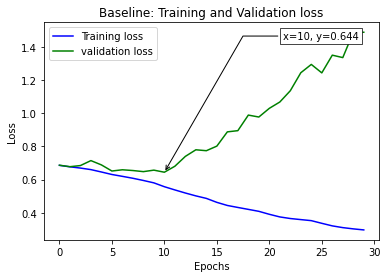

In [ ]:
epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

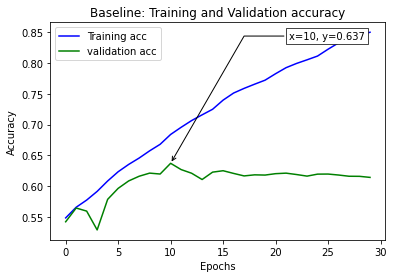

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
#######################
# normalzation
#######################

MODEL = 'resnet18'
path = MODEL_SAVE_PATH

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

[fold: 1]


Valid Epoch 29: 100%|██████████| 313/313 [00:15<00:00, 19.82batch/s, valid_acc=0.614, valid_loss=1.37]

[fold: 2]


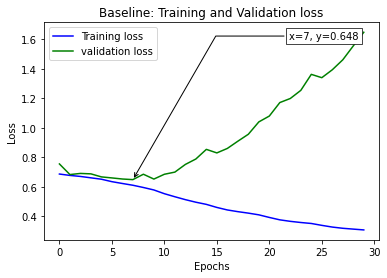

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

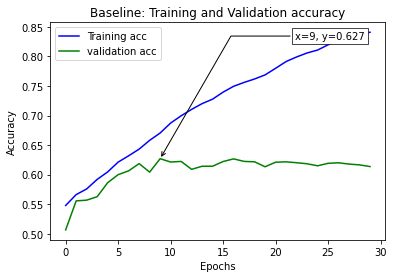

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

In [ ]:
##################################################################################################
##################################################################################################
##################################################################################################

In [ ]:
#######################
# SpinalNet
# RandomRotation 10
# RandompPerspective (might want to set distortion scale 0.2 or smaller later on)
# with normalization
#######################

train_transform = T.Compose([
                             T.RandomRotation(degrees=10),
                             T.RandomPerspective(0.2),
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])
eval_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])


kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

[fold: 1]


Valid Epoch 29: 100%|██████████| 313/313 [00:15<00:00, 20.05batch/s, valid_acc=0.609, valid_loss=1.36]

[fold: 2]


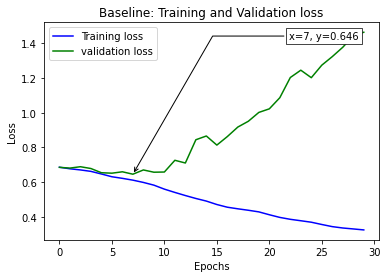

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

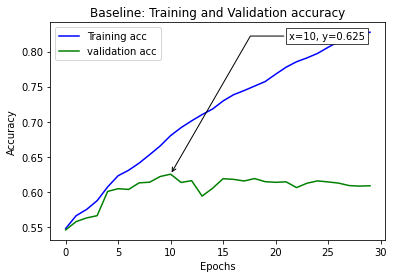

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
#######################
# SpinalNet
# RandomRotation 10
# RandompPerspective (might want to set distortion scale 0.2 or smaller later on)
# without normalization
#######################

train_transform = T.Compose([
                             T.RandomRotation(degrees=10),
                             T.RandomPerspective(0.2),
                             T.ToTensor()
])
eval_transform = T.Compose([
                             T.ToTensor()
])


kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

[fold: 1]


Valid Epoch 29: 100%|██████████| 313/313 [00:15<00:00, 19.94batch/s, valid_acc=0.608, valid_loss=1.31]

[fold: 2]


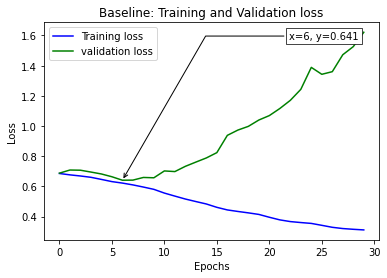

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

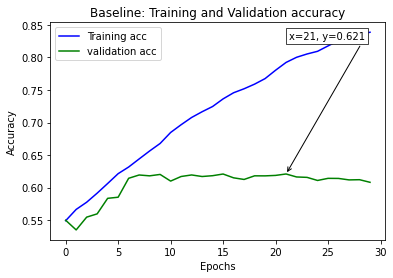

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
#######################
# SpinalNet
# RandomRotation 10
# no RandomPerspective
# with normalization
#######################

train_transform = T.Compose([
                             T.RandomRotation(degrees=10),
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])
eval_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])


kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

[fold: 1]


Valid Epoch 29: 100%|██████████| 313/313 [00:13<00:00, 23.86batch/s, valid_acc=0.612, valid_loss=1.09]


[fold: 2]


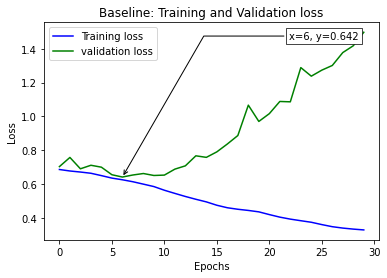

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

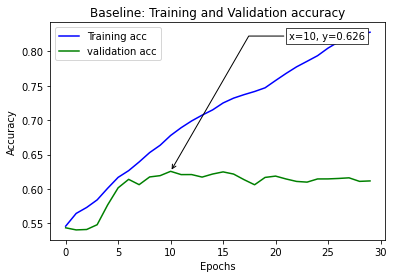

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
#######################
# SpinalNet
# RandomRotation 10
# no RandomPerspective
# no normalization
#######################

train_transform = T.Compose([
                             T.RandomRotation(degrees=10),
                             T.ToTensor(),
])
eval_transform = T.Compose([
                             T.ToTensor(),
])


kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

[fold: 1]


Valid Epoch 29: 100%|██████████| 313/313 [00:13<00:00, 23.03batch/s, valid_acc=0.623, valid_loss=1.52]

[fold: 2]


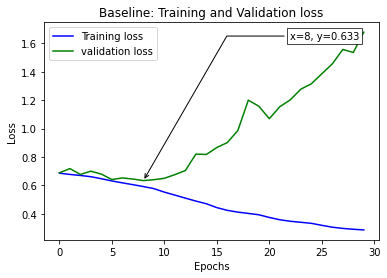

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

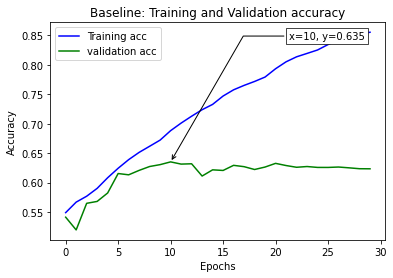

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
#######################
# 30 epochs 1 fold
# SpinalNet
# RandomRotation 90
# RandompPerspective
# with normalization
#######################

train_transform = T.Compose([
                             T.RandomRotation(degrees=90),
                             T.RandomPerspective(0.2),
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])
eval_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])

MODEL = 'resnet18'
path = MODEL_SAVE_PATH
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

[fold: 1]


Valid Epoch 29: 100%|██████████| 313/313 [00:13<00:00, 23.33batch/s, valid_acc=0.609, valid_loss=1.03]


[fold: 2]


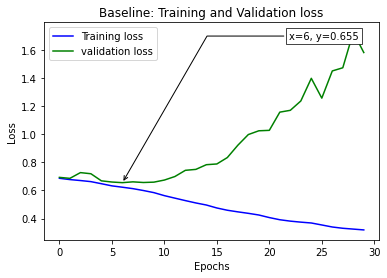

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

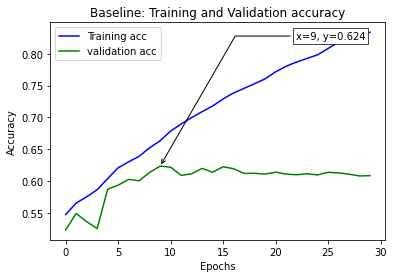

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
#######################
# 20 epochs 1 fold
# SpinalNet
# RandomRotation 180
# RandompPerspective
# with normalization
#######################

train_transform = T.Compose([
                             T.RandomRotation(degrees=180),
                             T.RandomPerspective(0.2),
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007)
])
eval_transform = T.Compose([
                            T.ToTensor(),
                            T.Normalize(0.5350, 0.3007)
])

MODEL = 'resnet18'
path = MODEL_SAVE_PATH

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

[fold: 1]


Valid Epoch 29: 100%|██████████| 313/313 [00:13<00:00, 23.60batch/s, valid_acc=0.613, valid_loss=1.17]


[fold: 2]


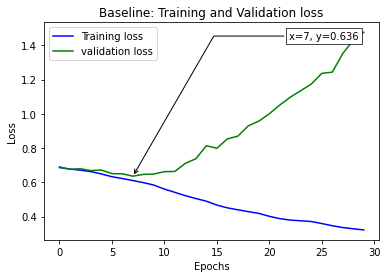

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

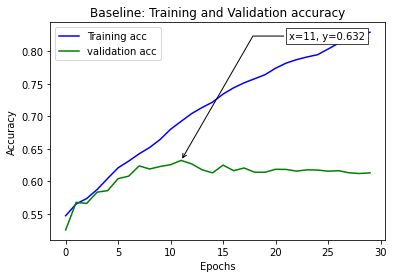

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
##################################################################################################
##################################################################################################
##################################################################################################

In [ ]:
#######################
# Efficient Capsnet
# RandomRotation 30
# Translation 2pixel for 28x28 image - x, y translation is independent [p=0.5]
# Width Compression 0 ~ 25%
# Random Erasure 4x4 for 28x28 (20x20)
#
# what i implemented:
# RandomRotation30
# RandomAffine - translation -10% ~ 10% of image size in x and y direction
# Resize only compress width from 256 to 220
# Pad right and left of image to make 256 256
# RandomErasing 1% ~ 2% of image with a square (p=0.5)
# Normalization
#######################

train_transform = T.Compose([
                             T.RandomRotation(degrees=30),
                             T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                             T.Resize((256, 220)),
                             T.Pad((18,0)),
                             T.ToTensor(),
                             T.RandomErasing(scale=(0.01, 0.02), ratio=(1,1)),
                             T.Normalize(0.5350, 0.3007),
])
eval_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])

MODEL = 'resnet18'
path = MODEL_SAVE_PATH

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
#######################
# Efficient Capsnet
# RandomRotation 30
# Translation 2pixel for 28x28 image - x, y translation is independent [p=0.5]
# Width Compression 0 ~ 25%
# Random Erasure 4x4 for 28x28 (20x20)
#
# what i implemented:
# RandomRotation30
# RandomAffine - translation -10% ~ 10% of image size in x and y direction
# Resize only compress width from 256 to 220
# Pad right and left of image to make 256 256
# RandomErasing 1% ~ 2% of image with a square (p=0.5) x 3 times
# Normalization
#######################

train_transform = T.Compose([
                             T.RandomRotation(degrees=30),
                             T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
                             T.Resize((256, 220)),
                             T.Pad((18,0)),
                             T.ToTensor(),
                             T.RandomErasing(scale=(0.01, 0.02), ratio=(1,1)),
                             T.RandomErasing(scale=(0.01, 0.02), ratio=(1,1)),
                             T.RandomErasing(scale=(0.01, 0.02), ratio=(1,1)),
                             T.Normalize(0.5350, 0.3007),
])
eval_transform = T.Compose([
                             T.ToTensor(),
                             T.Normalize(0.5350, 0.3007),
])

MODEL = 'resnet18'
path = MODEL_SAVE_PATH

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

train_loss_list = []
valid_loss_list = []
train_loss_list2 = []
valid_loss_list2 = []
train_acc_list2 = []
valid_acc_list2 = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 1:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, T.ToTensor())
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, T.ToTensor())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(30):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_loss_list.append(loss.item())
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        train_loss_list2.append(sum(train_loss_list) / len(train_data_loader))
        train_acc_list2.append(sum(train_acc_list) / len(train_data_loader))

        train_loss_list = []
        train_acc_list = []
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_loss_list.append(valid_loss.item())
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        valid_loss_list2.append(sum(valid_loss_list) / len(valid_data_loader))
        valid_acc_list2.append(sum(valid_acc_list) / len(valid_data_loader))

        valid_loss_list = []
        valid_acc_list = []
                
        lr_scheduler.step()

In [ ]:
valid_acc_list2 = np.array(valid_acc_list2)
valid_loss_list2 = np.array(valid_loss_list2)

epochs = range(30)
plt.plot(epochs, train_loss_list2, 'b', label='Training loss')
plt.plot(epochs, valid_loss_list2, 'g', label='validation loss')
plt.title('Baseline: Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
annot_min(epochs, valid_loss_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
epochs = range(30)
plt.plot(epochs, train_acc_list2, 'b', label='Training acc')
plt.plot(epochs, valid_acc_list2, 'g', label='validation acc')
plt.title('Baseline: Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
annot_max(epochs, valid_acc_list2, ax=None)
plt.legend()
plt.show()

In [ ]:
# done for today

In [ ]:
#######################
# baseline
#######################

MODEL = 'resnet18'
path = MODEL_SAVE_PATH

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

best_models = []

for fold_index, (trn_idx, val_idx) in enumerate(kfold.split(dirty_mnist_answer), 1):
    print(f'[fold: {fold_index}]')

    if fold_index > 2:
        break

    torch.cuda.empty_cache()

    train_answer = dirty_mnist_answer.iloc[trn_idx]
    test_answer = dirty_mnist_answer.iloc[val_idx]

    train_dataset = DatasetMNIST('dirty_mnist_2nd/', train_answer, train_transform)
    valid_dataset = DatasetMNIST('dirty_mnist_2nd/', test_answer, eval_transform)

    train_data_loader = DataLoader(
        train_dataset,
        batch_size = 128,
        shuffle = True,
        num_workers=3
    )
    # why shuffle = False?

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size = 32,
        shuffle = False,
        num_workers=3
    )

    model = MultiLabelResnet()
    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(),
                                lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=5,
                                                gamma=0.75)

    criterion = torch.nn.BCELoss()

    valid_acc_max = 0

    for epoch in range(10):
        train_acc_list = []

        with tqdm(train_data_loader,
                total=train_data_loader.__len__(),
                unit="batch") as train_bar:
            for images, labels in train_bar:
                train_bar.set_description(f'Train Epoch {epoch}')
                
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.train()

                with torch.set_grad_enabled(True):

                    probs = model(images)

                    loss = criterion(probs, labels)

                    loss.backward()

                    optimizer.step()

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()

                    preds = probs > 0.5

                    batch_acc = (labels == preds).mean()
                    train_acc_list.append(batch_acc)
                    train_acc = np.mean(train_acc_list)
                train_bar.set_postfix(train_loss=loss.item(),
                                    train_acc=train_acc)
                
        
        valid_acc_list = []
        with tqdm(valid_data_loader,
                total=valid_data_loader.__len__(),
                unit='batch') as valid_bar:
            for images, labels in valid_bar:
                valid_bar.set_description(f'Valid Epoch {epoch}')
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)

                model.eval()

                with torch.no_grad():
                    
                    probs = model(images)
                    valid_loss = criterion(probs, labels)

                    probs = probs.cpu().detach().numpy()
                    labels = labels.cpu().detach().numpy()
                    preds = probs > 0.5
                    batch_acc = (labels == preds).mean()
                    valid_acc_list.append(batch_acc)

                valid_acc = np.mean(valid_acc_list)
                valid_bar.set_postfix(valid_loss=valid_loss.item(),
                                    valid_acc=valid_acc)
                
        lr_scheduler.step()

        if valid_acc_max < valid_acc:
            valid_acc_max = valid_acc
            best_model = model
            torch.save(best_model, f'{path}{USER}_{fold_index}_{MODEL}.pth')
    best_models.append(best_model)



[fold: 1]


Valid Epoch 0: 100%|██████████| 313/313 [00:25<00:00, 12.22batch/s, valid_acc=0.486, valid_loss=0.729]


NameError: ignored